In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf

# Define the set of stocks

assets1 = ['^GSPC', 'GC=F', 'BND', 'CL=F']
assets2 = ['AAPL', 'MSFT', 'META', 'GOOG']
assets3 = ['^GSPC', 'GC=F']

stocks = [assets1, assets2, assets3]

# Set the start and end dates for the historical data
start_date = '2010-01-01'
end_date = '2018-12-31'

def returns(n, assets):
    # Retrieve the historical data for each stock
    df = yf.download(assets, start=start_date, end=end_date)['Adj Close']

    # Calculate the expected returns and risks of each stock
    returns = df.pct_change().mean()
    risks = df.pct_change().std()

    # print(returns)
    # Calculate the correlation matrix
    corr_matrix = df.pct_change().corr()

    # Define the parameters of the problem
    n_assets = n
    expected_returns = returns.values * 100
    covariance_matrix = corr_matrix.values
    target_return = 0.05
    w_min = np.zeros(n)
    w_max = np.ones(n)

    # Define the objective function
    def portfolio_variance(w, cov_matrix):
        return (w.T @ cov_matrix @ w)

    # Define the constraints
    def expected_return_constraint(w, expected_returns, target_return):
        return w.T @ expected_returns - target_return

    def weight_sum_constraint(w):
        return sum(w) - 1

    def max_weight_difference_constraint(w, max_difference):
        return max(w) - min(w) - max_difference

    constraints = [
        {'type': 'eq', 'fun': expected_return_constraint, 'args': (expected_returns, target_return)},
        {'type': 'eq', 'fun': weight_sum_constraint},
    ]

    # Set the initial guess for the solution
    w0 = np.ones(n_assets) / n_assets

    # Define the bounds
    bounds = tuple((w_min[i], w_max[i]) for i in range(n_assets))

    # Solve the problem
    result = minimize(portfolio_variance, w0, args=(covariance_matrix,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    # Print the results
    # print('Optimal portfolio weights:')
    # print(result.x)
    # print('Portfolio expected return:')
    # print(np.dot(result.x, expected_returns))
    # print('Portfolio variance:')
    # print(result.fun)


final = [returns(len(assets1), assets1), returns(len(assets2), assets2), returns(len(assets3), assets3)]

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed


In [ ]:
# Retrieve the historical data for each stock
df = yf.download(assets1, start=start_date, end=end_date)['Adj Close']

# Calculate the expected returns and risks of each stock
returns = df.pct_change().mean()
risks = df.pct_change().std()

# Calculate the correlation matrix
corr_matrix = df.pct_change().corr()

# Set the number of simulations and the size of the portfolio
num_simulations = 100000
portfolio_size = len(assets1)

# Initialize the arrays to store the simulation results
simulation_returns = np.zeros(num_simulations)
simulation_risks = np.zeros(num_simulations)
simulation_weights = np.zeros((num_simulations, portfolio_size))

# Run the simulations
for i in range(num_simulations):
    # Generate random weights for the portfolio
    weights = np.random.random(portfolio_size)
    weights /= np.sum(weights)

    # Calculate the expected return and risk of the portfolio
    expected_return = np.sum(returns * weights)
    expected_risk = np.sqrt(np.dot(weights.T, np.dot(corr_matrix, weights))) * np.sqrt(252)

    # Store the simulation results
    simulation_returns[i] = expected_return
    simulation_risks[i] = expected_risk
    simulation_weights[i, :] = weights


[*********************100%***********************]  4 of 4 completed


Optimal weights: [0.32588015 0.00073511 0.09175952 0.58162521]
Expected return: 0.0002776013067676856
Expected risk: 9.344322455867092


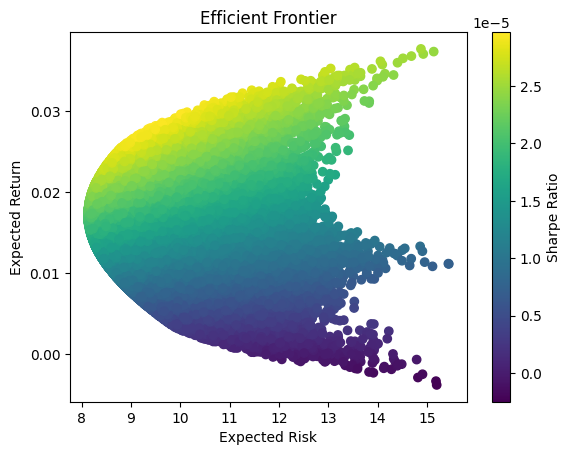

In [ ]:
# Calculate the Sharpe ratio for each simulation
sharpe_ratios = simulation_returns / simulation_risks

# Find the index of the simulation with the highest Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the weights of the optimal portfolio
optimal_weights = simulation_weights[max_sharpe_index, :]

# Print the results
print('Optimal weights:', optimal_weights)
print('Expected return:', simulation_returns[max_sharpe_index])
print('Expected risk:', simulation_risks[max_sharpe_index])

# Plot the efficient frontier
plt.scatter(simulation_risks, simulation_returns * 100, c=sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Risk')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import minimize

assets1 = ['^GSPC', 'GC=F', 'BND', 'CL=F']  ## SNP500, Gold, Bond, Crude Oil
assets2 = ['AAPL', 'MSFT', 'META', 'GOOG']  ## Apple, Microsoft, Facebook, Google
assets3 = ['^GSPC', 'GC=F'] ## SNP500, Gold

stocks = [assets1, assets2, assets3]

# Set the start and end dates for the historical data
start_date = '2005-01-01'
end_date = '2018-12-31'

def returns(n, assets):
  df = yf.download(assets, start=start_date, end=end_date)['Adj Close']

  # Calculate the expected returns and risks of each stock
  returns = df.pct_change().mean()
  risks = df.pct_change().std()

  # Calculate the correlation matrix
  corr_matrix = df.pct_change().corr()

  # Define the parameters of the problem
  n_assets = n
  expected_returns = returns.values
  covariance_matrix = corr_matrix.values

  # Define the target return and number of assets
  target_return = 0.1

  # Define the objective function
  def objective_function(weights, expected_returns, covariance_matrix, risk_aversion):
      portfolio_return = np.dot(weights.T, expected_returns)
      portfolio_risk = np.sqrt(np.dot(np.dot(weights.T, covariance_matrix), weights))
      return -(portfolio_return - (risk_aversion/2) * portfolio_risk ** 2)

  # Define the constraints
  constraints = ({'type': 'eq', 'fun': lambda weights: sum(weights) - 1})

  # Define the Lagrange multiplier
  risk_aversion = 1

  # Set the initial guess for the solution
  w0 = np.ones(n_assets) / n_assets

  # Define the bounds
  bounds = tuple((-1, 1) for i in range(n_assets))

  # Solve the problem
  result = minimize(objective_function, w0, args=(expected_returns, covariance_matrix, risk_aversion),
                    method='SLSQP', bounds=bounds, constraints=constraints)

  # Print the results
  print('Optimal portfolio weights:')
  print(result.x)
  print('Portfolio variance:')
  print(np.dot(np.dot(result.x, covariance_matrix), result.x))

final = [returns(len(assets1), assets1), returns(len(assets2), assets2), returns(len(assets3), assets3)]

[*********************100%***********************]  4 of 4 completed
Optimal portfolio weights:
[0.33064502 0.17248511 0.20619404 0.29067583]
Portfolio variance:
0.28216655060666446
[*********************100%***********************]  4 of 4 completed
Optimal portfolio weights:
[0.26932649 0.14712133 0.33725881 0.24629338]
Portfolio variance:
0.5392967338414475
[*********************100%***********************]  2 of 2 completed
Optimal portfolio weights:
[0.5 0.5]
Portfolio variance:
0.5016031041819854


In [ ]:
import pandas_datareader.data as web
import datetime
import pandas as pd

In [ ]:
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2021, 1, 22)

datetime.datetime(2021, 1, 1, 0, 0)

In [ ]:
ceva = web.DataReader('CEVA', 'yahoo', start, end)
google = web.DataReader('GOOGL', 'yahoo', start, end)
tesla = web.DataReader('TSLA', 'yahoo', start, end)
zom = web.DataReader('ZOM', 'yahoo', start, end)

TypeError: ignored